# DQN/DDQN Reinforcement Learning Agent for Navigation 

---

In this notebook we briefly summarize the implementation details and training results of the agent implemented in this repository.

For the ease of readability we start with an overview of the implemented algorithms and the achieved results in the first section, and continue with a detailed walk through the [Implementation](#1.-Implementation) in the section thereafter.

## 2. Algorithm and Results

In the following sections we give a brief overview of the general setup and the implemented algorithms. A detailed introduction to Markov Decision Processes and Reinforcement learning can be found e.g. in [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html). For further details also see the referenced articles.

### 1.1 General setting

The agent navigates in a predefined environment that represents a square world were it has to collect bananas. A reward $r$ of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The problem is formalized as a *Markov Decision Process* (MDP), where the state space of the agent's environment is represented by a 37 dimensional vector $s$ of real numbers and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions $a$ are available, corresponding to:

    0 - move forward.
    1 - move backward.
    2 - turn left.
    3 - turn right.

The task is episodic, and the environment is considered solved if the agent is able to achieve an average score of +13 over 100 consecutive episodes.

### 1.2 Q-Learning algorithm and implemented variants

In [Q-learning](https://en.wikipedia.org/wiki/Q-learning) we try to approximate the optimal action-value function $Q^*(s, a)$, i.e. the expected overall discounted reward following an optimal policy $\pi^*$, of the Markov Decision Process:
$$
Q(s,a) \approx Q^*_{\pi*}(s,a) = \mathbb{E}_{\pi^*} \left[\sum_{i=0}^{\infty} \gamma^i r_i \right],
$$
where $\gamma$ is a discount rate that determines the weight of future return values, i.e. how far the agent looks into the future. Based on the approixmator $Q(s,a)$ the agent can derive a policy $\pi$ by choosing the action with the optimal value in each state.

For our problem we will use parameterized function approximators $Q(s, a, \theta)$ based on deep neural networks (DNN). To optimize this function approximators $Q(s, a, \theta)$ we will minimize loss functions (see below) that are based on the *Bellman optimality equation*
$$
Q^*(s, a) = \mathbb{E} \left[R_{t+1} + \gamma \max_{a'} Q^*(S_{t+1}, a') \, \big |  \, S_t=s, A_t=a \right],
$$
which provides a condition that the optimal value function $Q^*(s,a)$ must satisfy. 

#### Learning algorithm

The learning follows an iterative algorithm which can be described on a high level as:
- Initialize Q
- for i episodes:
    - derive a ($\epsilon$-greedy) policy $\pi$ from $Q$
    - generate experience $s_0, a_0, r_0, s_1, a_1, \dots$ from an episode using $\pi$
    - optimize $\theta$ from the experience to reduce the loss

In this repository two variants of function approximation based Q-Learning algorithms are implemented:

#### DQN
This is a variant of Q-learning with a DNN as approximator for the Q-function, using a *fixed target* and *experience replay*. In this variant the following loss function is minimized: 
$$
L^{\scriptscriptstyle \rm DQN}(\theta) = \mathbb{E}_{s_t,a_t,s_{t+1},a_{t+1}} \left[r_{t+1} + \gamma \max_{a_{t+1}} Q(s_{t+1}, a_{t+1}, \theta') - Q(s_t,a_t, \theta) \right].
$$
This loss function uses a second parameter $\theta'$ (*fixed target*) that is temporarily fixed during the learning process, or is, like in our implementation, updated at a lower pace by a soft-update function $θ' \leftarrow \tau\theta + (1 - \tau)\theta'$. During the optimization process a technique called *experience replay* is applied, which means that states experienced during the exectution of the Markov process are stored in a replay memory and sampled independently from this memory during learning. Both techniques improve the stability of the learning algorithm, for a more detailed description see [this paper](https://www.nature.com/articles/nature14236).
#### DDQN
In Double Q-learning (*DDQN*), the loss function of the DQN algorithm is slightly modified to decouple the choice of the optimal action from the estimation of the actual value of the Q-function by using different approximators for the Q-function's value and the action selection at timestep $t+1$ (note the different parameters $\theta$ and $\theta'$):
$$
L^{\scriptscriptstyle \rm DDQN}(\theta) = \mathbb{E}_{s_t,a_t,s_{t+1},a_{t+1}} \left[r_{t+1} + \gamma Q(s_{t+1}, \max_{a_{t+1}}Q(s_{t+1},a_{t+1}, \theta), \theta') - Q(s_t,a_t, \theta) \right],
$$
to address issues that the DQN algorithm experiences with regard to overestimating the actual value of the Q function. Further details can be found [here](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12389/11847).


### 1.3 Network architectures

Two different architectures of DNNs as function approximators were examined:

- a *simple* variant with two hidden layers of 64 units each:
![Simple DNN](resources/simple_dnn.png)
- a more advanced architecture that is extended with two additional hidden layers with 16 and 8 units at the input side of the DNN. This two layers are intended to work similar to the encoder part of an [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) architecture and extract features from the raw state:
![AutoEnc DNN](resources/autoenc_dnn.png)

### 1.4 Hyperparameter choices

For all implemented algorithm and model architectures the same set of the following hyper-parameters was used:

- A discount rate $\gamma=0.99$ close to one was chosen, as it is expected that an action of the agent will result in a reward only after several future steps. As expected, the choice of low discount rates resulted in a notable decrease of performance.
- The size of the memory for experience replay was choosen to hold about 100 episodes (of 300 steps each), and every 4 steps 4 randomly chosen batches of 64 samples were drawn from the replay memory.
- During execution of the episodes the agent used an $\epsilon$-greedy policy, with a start value if $\epsilon = 1.0$ (high exploration), gradually declining to a minimum value of 0.01 (high exploitation) within about 1000 episodes.
- The target parameters $\theta'$ of the Q-function in DQN and DDQN were updated with a soft-update weight parameter of $\tau = 10^{-3}$ after every processed batch.
- For weight updates a constant learning learning rate of $10^{-4}$ turned out to deliver good results.


### 1.5 Performance
The following plot displays the performance for the different algorithm and network architecture choices. The average final score of each episode, averaged over the last 100 episodes is drawn against the number of episodes executed for learning:
![Scores](results/multi_model.scores.png)
As seen from the plot, the target performance of an average score of +13 is achieved by all combinations of algorithm and model within about 500-600 episodes. The best final performance with an average score of 17.4 averaged over 100 episodes is delivered by the auto-encoder like DNN architecture in combination with the DDQN algorithm, though all variants get close to this value at some point.

Overall, all the implemented variants perform very simmilar, and the main performance improvements that were taken to achieve the above result were improvements of the hyper-parameter choices, especially for learning rate, batch size and the replay memory size. With this in mind a clear statement on the difference in performance of the various implemented variants is not justified from the observed results, as the choosen hyper-parameters might as well be more optimal for some of the variants than for others. 

Finally we also include a plot of the episode scores and the loss. Notable is that the loss in fact increases during the learning process, which comes from the fact that the loss is calculated against a constantly changing target $Q(s,a,\theta')$.

Scores | Losses
-|-
![DDQN_Scores](results/ddqn_simple_model.scores.png)| ![DDQN_Loss](results/ddqn_simple_model.losses.png)

The loss values in the above plot are the loss of the last learning step in each episode (due to a mistake in the code). A similar, but a bit more sensible plot with the average loss of each episode can be found at the bottom of this notebook.

#### Result files

Results of the executed learning process, in particular the paramters for the trained DNNs can be found in the [results/](../tree/results) folder. The agent with the trained parameters can be executed from the command line invoking the *banananavigation.py* script with the *--replay* option as described in the [README](../tree/README.md). 

### 1.6 Further Improvements

Considering the high fluctuations in the above plots both for scores and losses the following ways could be explored to achieve further performance improvements:

One route to explore could be further hyper-parameter improvements to stabilize the learning in the later phase. This could be a gradually decreasing learning rate/increasing batch size, a progressive increase of the discount factor or a progressive increase of the soft-update weight $\tau$ .

Given the high variance of the loss, another direction could be to improve the sampling from the replay memory using [prioritized experienced replay](https://arxiv.org/abs/1511.05952), which puts more focus on experience points that result in high loss values.

## 2. Implementation

In this section we provide a detailed walk through the implementation. To reproduce the above results, however, run the 
banananavigation script from the command line as described in the README without command line parameters.

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [13]:
from pprint import pprint

import pkg_resources
import random
import torch
from torch import optim
import torch.nn.functional as F
import numpy as np
from collections import namedtuple

from unityagents import UnityEnvironment
from unityagents.exception import UnityEnvironmentException

from banananav.environment import PLATFORM_PATHS


### 2.1. Environment

The environment in which the agent operates is based on a predefined [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) environment was installed in [banananav/resources/](../tree/banananav/resources/) folder during the setup described in the [README](../tree/README.md).

To navigate the environment the [environment.py module](../tree/banananav) provides a `BananaAgent` class that chooses an action for a given state of the environment based on a provided Q-Function:

In [2]:
# %load -s BananaAgent banananav/environment.py
class BananaAgent:
    """Agent based on a Q-function."""

    def __init__(self, Q, action_size, epsilon=0.0):
        """Initialize the agent.

        Args:
            Q: Q-function that is callable with a state and returns a 1-dim
                array-like containing the q-values for each action.
            action_size: The number of available actions.
            epsilon: propability for the agent to choose the action uniformly
                from the available actions instead of based on the Q-function,
                defaults to 0.0.
        """
        self._Q = Q
        self._action_size = action_size
        self._epsilon = epsilon

    def act(self, state):
        """Select an action for the given state.

        Args:
            state: The state to choose the action for.
        Returns:
            An int representing the action.
        """
        if not torch.is_tensor(state):
            try:
                state = torch.from_numpy(state)
            except:
                state = torch.from_numpy(np.array(state, dtype=np.float))

        state = state.float()

        if self._epsilon == 0.0 or random.uniform(0, 1) > self._epsilon:
            with torch.no_grad():
                return torch.argmax(self._Q(state)).item()

        return np.random.randint(self._action_size)


 and a `BananaEnv` class that provides an interface that allows to navigate the environment with an instance of the `BananaAgent`.

In [3]:
# %load -s BananaEnv banananav/environment.py
class BananaEnv:
    """Banana collection environment.

    The environment accepts actions and provides states and rewards in response.
    """

    def __init__(self):
        for path in PLATFORM_PATHS:
            try:
                unity_resource = pkg_resources.resource_filename('banananav', 'resources/' + path)
                self._env = UnityEnvironment(file_name=unity_resource)
                print("Environment loaded from " + path)
                break
            except UnityEnvironmentException as e:
                print("Attempted to load " + path + ":")
                print(e)
                print("")
                pass

        if not hasattr(self, '_env'):
            raise Exception("No unity environment found, setup the environment as described in the README.")

        # get the default brain
        self._brain_name = self._env.brain_names[0]
        self._brain = self._env.brains[self._brain_name]

        self._info = None
        self._score = None

    def generate_episode(self, agent, max_steps=None, train_mode=False):
        """Create a generator for and episode driven by an actor.
        Args:
            actor: An actor that provides the next action for a given state.
            max_steps: Maximum number of steps (int) to take in the episode. If
                None, the episode is generated until a terminal state is reached.

        Returns:
            A generator providing a tuple of the current state, the action taken,
            the obtained reward, the next state and a flag whether the next
            state is terminal or not.
        """
        state = self.reset(train_mode=train_mode)
        is_terminal = False
        count = 0

        while not is_terminal and (max_steps is None or count < max_steps):
            action = agent.act(state)
            reward, next_state, is_terminal = self.step(action)

            step_data = (state, action, reward, next_state, is_terminal)

            state = next_state
            count += 1

            yield step_data

    def reset(self, train_mode=False):
        """Reset and initiate a new episode in the environment.

        Args:
            train_mode: Indicate if the environment should be initiated in
                training mode or not.

        Returns:
            The initial state of the episode (np.array).
        """
        if self._info is not None and not self._info.local_done[0]:
            raise Exception("Env is active, call terminate first")

        self._info = self._env.reset(train_mode=train_mode)[self._brain_name]
        self._score = 0

        return self._info.vector_observations[0]

    def step(self, action):
        """Execute an action.

        Args:
            action: An int representing the actionself.

        Returns:
            A tuple containing the reward (float), the next state (np.array) and
            a boolean indicating if the next state is terminal or not.
        """
        if self._info is None:
            raise Exception("Env is not active, call reset first")

        self._info = self._env.step(action)[self._brain_name]
        next_state = self._info.vector_observations[0]
        reward = self._info.rewards[0]
        is_terminal = self._info.local_done[0]
        self._score += reward

        return reward, next_state, is_terminal

    def terminate(self):
        self._info = None
        self._score = None

    def close(self):
        self._env.close()
        self._info = None

    def get_score(self):
        """Return the cumulative reward of the current episode."""
        return self._score

    def get_action_size(self):
        return self._brain.vector_action_space_size

    def get_state_size(self):
        return self._brain.vector_observation_space_size


In [4]:
### RUN THIS CELL ONLY ONCE!! ###
env = BananaEnv()
pprint("state size: " + str(env.get_state_size()))
pprint("state size: " + str(env.get_action_size()))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environment loaded from Banana.app
'state size: 37'
'state size: 4'


To test the environment let us run a view steps with a random agent:

In [5]:
dummy_Q = lambda s: (torch.arange(4) == s[0]).float()
agent = BananaAgent(dummy_Q, 4)

for step, step_data in enumerate(env.generate_episode(agent, max_steps=10)):
    state, action, reward, next_state, is_terminal = step_data
    pprint("============= Current step: " + str(step))
    pprint("state:")
    pprint(state)
    pprint("action: " + str(action))
    pprint("next state:")
    pprint(next_state)
    pprint("reward:" + str(reward))
    pprint("is terminal state: " + str(is_terminal))
    
    
env.terminate()

'============= Current step: 0'
'state:'
array([1.        , 0.        , 0.        , 0.        , 0.84408134,
       0.        , 0.        , 1.        , 0.        , 0.0748472 ,
       0.        , 1.        , 0.        , 0.        , 0.25755   ,
       1.        , 0.        , 0.        , 0.        , 0.74177343,
       0.        , 1.        , 0.        , 0.        , 0.25854847,
       0.        , 0.        , 1.        , 0.        , 0.09355672,
       0.        , 1.        , 0.        , 0.        , 0.31969345,
       0.        , 0.        ])
'action: 1'
'next state:'
array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.34574997,
        0.        ,  0.        ,  1.        ,  0.        ,  0.08556978,
        0.        ,  1.        ,  0.        ,  0.        ,  0.26330134,
        0.        ,  1.        ,  0.        ,  0.        ,  0.90327591,
        0.        ,  1.        ,  0.        ,  0.        ,  0.2643221 ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.10695964,


'============= Current step: 6'
'state:'
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.79221481e-01,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.15355480e-01,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.86902952e-01,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.16578090e-01,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.83091533e-01,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.91446769e-01, -1.78813934e-07,
        1.67893946e+00])
'action: 0'
'next state:'
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.66466892e-01,  0.00000000e+00,  1.00000000e+00,
        

### 2.2. Model implementation

The DNN models are implemented as PyTorch modules:

In [6]:
# %load banananav/qmodel.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class BananaQModel(nn.Module):
    """Q Function Approximator with autoencode-like step."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Args:
            state_size: Dimension of each state (int)
            action_size: number of actions (int)
        """
        super(BananaQModel, self).__init__()
        self.fc1 = nn.Linear(state_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.softmax(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        return self.fc5(x)

class SimpleBananaQModel(nn.Module):
    """Q Function Approximator."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Args:
            state_size: Dimension of each state (int)
            action_size: number of actions (int)
        """
        super(SimpleBananaQModel, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        return self.fc3(x)


### 2.3. Q-learing algorithm implementation

The DQN algorithm is implemented in the `DeepQLearner` class, which also takes care of the episode creation needed for the learning process:

In [7]:
from banananav.replaymemory import ReplayMemory

In [8]:
# %load -s DeepQLearner banananav/training.py
class DeepQLearner():
    """Implementation of the DQN learning algorithm with experience replay.
    """

    def __init__(self, env=None, model=BananaQModel, memory=ReplayMemory(int(3e4)),
            batch_steps=4, batch_size=64, batch_repeat=4,
            lr=1e-4, decay=0.001,
            epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995,
            gamma=0.99, tau=1e-3):
        self._memory = memory
        # Don't instantiate as default as the constructor already starts the unity environment
        self._env = env if env is not None else BananaEnv()

        self._state_size = self._env.get_state_size()
        self._actions = self._env.get_action_size()

        self._batch_steps = batch_steps
        self._batch_size = batch_size
        self._batch_repeat = batch_repeat

        self._epsilon_start=epsilon_start
        self._epsilon_min=epsilon_min
        self._epsilon_decay=epsilon_decay
        self._gamma = gamma
        self._tau = tau

        self._qnetwork_local = model(self._state_size, self._actions).to(device)
        self._qnetwork_target = model(self._state_size, self._actions).to(device)
        self._optimizer = optim.Adam(self._qnetwork_local.parameters(), lr=lr,
            amsgrad=True)

        self._qnetwork_local.eval()
        self._qnetwork_target.eval()

    def save(self, path):
        """Store the learning result.

        Store the parameters of the current Q-function approximation to the given path.
        """
        torch.save(self._qnetwork_local.state_dict(), path)

    def load(self, path):
        """Load learning results.

        Load the parameters from the given path into the current and target
        Q-function approximator.
        """
        self._qnetwork_local.load_state_dict(torch.load(path))
        self._qnetwork_target.load_state_dict(torch.load(path))
        self._qnetwork_local.to(device)
        self._qnetwork_target.to(device)

    def get_agent(self, epsilon=0.0):
        """Return an agent based on the parameters of the current Q-function approximation.
        """
        return BananaAgent(self._qnetwork_local, self._env.get_action_size(),
                epsilon=epsilon)

    def train(self, num_episodes=100):
        episodes = ( self._env.generate_episode(
                        self.get_agent(self._get_epsilon(cnt)), train_mode=True)
                for cnt in range(num_episodes) )
        steps = ( (cnt, step_cnt, step_data)
                for cnt, episode in enumerate(episodes)
                for step_cnt, step_data in enumerate(episode) )

        for episode, step, step_data in steps:
            self._memory.add(*step_data)

            if (step % self._batch_steps == 0 or self._is_terminal(step_data)) \
                    and self._memory.size() >= self._batch_size:
                for i in range(1 if self._memory.size() < 1000 else self._batch_repeat):
                    loss = self._train_from_memory()
                    self._update_target()
                yield loss, self._env.get_score(), self._is_terminal(step_data)

    def _get_epsilon(self, cnt):
        return max(self._epsilon_min, self._epsilon_decay ** cnt * self._epsilon_start)

    def _train_from_memory(self):
        self._qnetwork_local.train()

        batch = self._memory.sample(self._batch_size)
        loss = self._calculate_loss(*zip(*batch))

        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

        self._qnetwork_local.eval()

        return loss

    def _calculate_loss(self, states, actions, rewards, next_states, is_terminal):
        states, next_states, rewards, is_terminal = self._to_tensor(states, next_states, rewards, is_terminal)
        actions = self._to_tensor(actions, dtype=torch.long)[0]

        rewards = rewards.unsqueeze(1)
        is_terminal = is_terminal.unsqueeze(1)
        actions = actions.unsqueeze(1)

        Q_target_next = self._qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_target = rewards + (self._gamma * Q_target_next * (1 - is_terminal))
        Q_predicted = self._qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_target, Q_predicted)

        # Validate dimensions
        assert Q_predicted.size()[0] == states.size()[0]
        assert Q_predicted.size()[1] == 1
        assert Q_predicted.size() == Q_target_next.size() == Q_target.size() \
                == rewards.size() == is_terminal.size() == actions.size()

        return loss

    def _update_target(self):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        """
        parameters = zip(self._qnetwork_target.parameters(), self._qnetwork_local.parameters())

        for target_param, local_param in parameters:
            update = self._tau * local_param.data + (1.0 - self._tau) * target_param.data
            target_param.data.copy_(update)

    def _is_terminal(self, state_data):
        return state_data[-1]

    def _get_reward(self, state_data):
        return state_data[2]

    def _to_tensor(self, *arrays, dtype=torch.float):
        return tuple(torch.tensor(a).to(device, dtype=dtype) for a in arrays)


This class is sub-classed by `DoubleDeepQLearner` with the modified loss calculation for the Double Q-Learning algorithm: 

In [9]:
# %load -s DoubleDeepQLearner banananav/training.py
class DoubleDeepQLearner(DeepQLearner):
    """Implementation of the Double-DQN learning algorithm with experience replay.
    """

    def __init__(self, env=None, model=BananaQModel, memory=ReplayMemory(int(3e4)),
            batch_steps=4, batch_size=64, batch_repeat=4,
            lr=1e-4, decay=0.001,
            epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995,
            gamma=0.99, tau=1e-3):
        super(DoubleDeepQLearner, self).__init__(env=env, model=model, memory=memory,
                batch_steps=batch_steps, batch_size=batch_size, batch_repeat=batch_repeat,
                lr=lr, decay=decay,
                epsilon_start=epsilon_start, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                gamma=gamma, tau=tau)

    def _calculate_loss(self, states, actions, rewards, next_states, is_terminal):
        states, next_states, rewards, is_terminal = self._to_tensor(states, next_states, rewards, is_terminal)
        actions = self._to_tensor(actions, dtype=torch.long)[0]

        rewards = rewards.unsqueeze(1)
        is_terminal = is_terminal.unsqueeze(1)
        actions = actions.unsqueeze(1)

        Q_local_next_choices = self._qnetwork_local(next_states).max(1)[1].unsqueeze(1)
        Q_target_next = self._qnetwork_target(next_states).detach().gather(1, Q_local_next_choices)
        Q_target = rewards + (self._gamma * Q_target_next * (1 - is_terminal))
        Q_predicted = self._qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_target, Q_predicted)

        # Validate dimensions
        assert Q_local_next_choices.size() == actions.size()
        assert Q_predicted.size()[0] == states.size()[0]
        assert Q_predicted.size()[1] == 1
        assert Q_predicted.size() == Q_target_next.size() == Q_target.size() \
                == rewards.size() == is_terminal.size() == actions.size()

        return loss


### 2.4. Execute learning

Now we can put the parts above together, run the learner and 


In [10]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from banananav.util import print_progress, plot

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env.terminate()

## Select DeepQLearner or DoubleDeepQLearner here, using
## BananaQModel or SimpleBananaQModel
learner = DeepQLearner(env=env, model=BananaQModel)

scores = ()
losses = ()

episode_cnt = 0
episode_step = 0
episode_losses = ()
for cnt, data in enumerate(learner.train(750)):
    episode_step += 1
    loss, score, terminal = data
    episode_losses += (loss.item(), )

    if terminal:
        scores += (score, )
        losses += (np.mean(episode_losses), )
        episode_losses = ()
        episode_cnt += 1
        episode_step = 0

    print_progress(episode_cnt, episode_step, loss, scores)
    if terminal:
        print("")

/Users/tkb/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1/0 [------------------------------------------------------------] loss: +1.640E-03 / score: +0.000(+0/+0/+0)
2/0 [------------------------------------------------------------] loss: +2.706E-05 / score: -0.500(-1/-1/+0))
3/0 [------------------------------------------------------------] loss: +9.038E-05 / score: -0.667(-1/-1/+0))
4/0 [------------------------------------------------------------] loss: +1.564E-02 / score: -0.750(-1/-1/+0))
5/0 [------------------------------------------------------------] loss: +1.225E-05 / score: -0.600(-1/+0/+0))
6/0 [------------------------------------------------------------] loss: +2.021E-05 / score: -0.667(-1/-1/+0))
7/0 [------------------------------------------------------------] loss: +1.575E-02 / score: -0.429(-1/+1/+1))
8/0 [------------------------------------------------------------] loss: +1.471E-04 / score: -0.500(-1/-1/+1))
9/0 [------------------------------------------------------------] loss: +1.521E-02 / score: -0.444(-1/+0/+1))
10

74/0 [------------------------------------------------------------] loss: +3.228E-02 / score: +0.554(-3/+2/+5))
75/0 [------------------------------------------------------------] loss: +8.496E-04 / score: +0.587(-3/+3/+5))
76/0 [------------------------------------------------------------] loss: +1.632E-02 / score: +0.566(-3/-1/+5))
77/0 [------------------------------------------------------------] loss: +1.123E-03 / score: +0.610(-3/+4/+5))
78/0 [------------------------------------------------------------] loss: +1.452E-03 / score: +0.590(-3/-1/+5))
79/0 [------------------------------------------------------------] loss: +1.186E-03 / score: +0.620(-3/+3/+5))
80/0 [------------------------------------------------------------] loss: +1.730E-02 / score: +0.650(-3/+3/+5))
81/0 [------------------------------------------------------------] loss: +1.805E-02 / score: +0.691(-3/+4/+5))
82/0 [------------------------------------------------------------] loss: +1.391E-03 / score: +0.671(-3/

146/0 [------------------------------------------------------------] loss: +2.727E-02 / score: +1.880(-3/+1/+7))
147/0 [------------------------------------------------------------] loss: +1.537E-02 / score: +1.860(-3/+2/+7))
148/0 [------------------------------------------------------------] loss: +3.088E-02 / score: +1.910(-3/+6/+7))
149/0 [------------------------------------------------------------] loss: +4.609E-02 / score: +1.960(-3/+5/+7))
150/0 [------------------------------------------------------------] loss: +3.847E-02 / score: +1.980(-3/+2/+7))
151/0 [------------------------------------------------------------] loss: +1.006E-02 / score: +2.000(-3/+4/+7))
152/0 [------------------------------------------------------------] loss: +2.453E-02 / score: +2.030(-3/+2/+7))
153/0 [------------------------------------------------------------] loss: +1.132E-02 / score: +2.030(-3/+1/+7))
154/0 [------------------------------------------------------------] loss: +1.983E-02 / score: +

218/0 [------------------------------------------------------------] loss: +3.894E-02 / score: +4.020(+0/+6/+11))
219/0 [------------------------------------------------------------] loss: +1.924E-02 / score: +4.100(+0/+11/+11)
220/0 [------------------------------------------------------------] loss: +1.765E-02 / score: +4.170(+0/+8/+11)1)
221/0 [------------------------------------------------------------] loss: +1.959E-02 / score: +4.150(+0/+5/+11))
222/0 [------------------------------------------------------------] loss: +1.441E-02 / score: +4.240(+0/+9/+11))
223/0 [------------------------------------------------------------] loss: +3.485E-02 / score: +4.300(+0/+9/+11))
224/0 [------------------------------------------------------------] loss: +3.211E-02 / score: +4.310(+0/+5/+11))
225/0 [------------------------------------------------------------] loss: +4.236E-02 / score: +4.340(+0/+4/+11))
226/0 [------------------------------------------------------------] loss: +2.112E-02 /

289/0 [------------------------------------------------------------] loss: +3.583E-02 / score: +7.060(+0/+9/+15)5)
290/0 [------------------------------------------------------------] loss: +1.071E-01 / score: +7.110(+0/+8/+15))
291/0 [------------------------------------------------------------] loss: +5.586E-02 / score: +7.150(+0/+10/+15)
292/0 [------------------------------------------------------------] loss: +6.716E-02 / score: +7.270(+0/+15/+15))
293/0 [------------------------------------------------------------] loss: +3.256E-02 / score: +7.290(+0/+10/+15))
294/0 [------------------------------------------------------------] loss: +9.485E-02 / score: +7.300(+0/+8/+15)5)
295/0 [------------------------------------------------------------] loss: +1.108E-02 / score: +7.340(+0/+10/+15)
296/0 [------------------------------------------------------------] loss: +1.690E-02 / score: +7.380(+0/+8/+15)5)
297/0 [------------------------------------------------------------] loss: +5.075E-

360/0 [------------------------------------------------------------] loss: +3.074E-02 / score: +9.640(+1/+5/+21)1)
361/0 [------------------------------------------------------------] loss: +1.291E-02 / score: +9.620(+1/+9/+21))
362/0 [------------------------------------------------------------] loss: +1.256E-02 / score: +9.700(+1/+15/+21)
363/0 [------------------------------------------------------------] loss: +2.856E-02 / score: +9.650(+1/+3/+21)1)
364/0 [------------------------------------------------------------] loss: +2.583E-02 / score: +9.700(+1/+9/+21))
365/0 [------------------------------------------------------------] loss: +1.002E-01 / score: +9.740(+1/+14/+21)
366/0 [------------------------------------------------------------] loss: +1.619E-02 / score: +9.770(+1/+10/+21))
367/0 [------------------------------------------------------------] loss: +3.887E-02 / score: +9.800(+1/+11/+21))
368/0 [------------------------------------------------------------] loss: +3.224E-0

430/0 [------------------------------------------------------------] loss: +2.589E-02 / score: +10.710(+1/+15/+21))
431/0 [------------------------------------------------------------] loss: +3.924E-02 / score: +10.740(+1/+8/+21)1)
432/0 [------------------------------------------------------------] loss: +2.575E-02 / score: +10.770(+1/+10/+21)
433/0 [------------------------------------------------------------] loss: +1.513E-02 / score: +10.760(+1/+13/+21))
434/0 [------------------------------------------------------------] loss: +2.894E-02 / score: +10.780(+1/+11/+21))
435/0 [------------------------------------------------------------] loss: +2.431E-02 / score: +10.830(+1/+18/+21))
436/0 [------------------------------------------------------------] loss: +1.823E-02 / score: +10.920(+1/+16/+21))
437/0 [------------------------------------------------------------] loss: +2.603E-02 / score: +11.000(+1/+17/+21))
438/0 [------------------------------------------------------------] loss

500/0 [------------------------------------------------------------] loss: +2.633E-02 / score: +12.370(+2/+16/+22))
501/0 [------------------------------------------------------------] loss: +1.636E-02 / score: +12.430(+2/+18/+22))
502/0 [------------------------------------------------------------] loss: +3.031E-02 / score: +12.390(+2/+14/+22))
503/0 [------------------------------------------------------------] loss: +1.506E-02 / score: +12.430(+2/+14/+22))
504/0 [------------------------------------------------------------] loss: +2.535E-02 / score: +12.460(+2/+15/+22))
505/0 [------------------------------------------------------------] loss: +2.609E-01 / score: +12.530(+2/+15/+22))
506/0 [------------------------------------------------------------] loss: +1.425E-02 / score: +12.540(+2/+16/+22))
507/0 [------------------------------------------------------------] loss: +3.343E-02 / score: +12.560(+2/+17/+22))
508/0 [------------------------------------------------------------] los

570/0 [------------------------------------------------------------] loss: +1.320E-02 / score: +14.440(+6/+15/+20))
571/0 [------------------------------------------------------------] loss: +3.217E-02 / score: +14.430(+6/+14/+20))
572/0 [------------------------------------------------------------] loss: +3.718E-02 / score: +14.350(+6/+9/+20)0)
573/0 [------------------------------------------------------------] loss: +3.262E-02 / score: +14.350(+6/+13/+20)
574/0 [------------------------------------------------------------] loss: +1.967E-02 / score: +14.380(+6/+16/+20))
575/0 [------------------------------------------------------------] loss: +1.670E-02 / score: +14.430(+6/+16/+20))
576/0 [------------------------------------------------------------] loss: +1.709E-02 / score: +14.360(+6/+8/+20)0)
577/0 [------------------------------------------------------------] loss: +1.521E-02 / score: +14.360(+6/+15/+20)
578/0 [------------------------------------------------------------] loss:

640/0 [------------------------------------------------------------] loss: +1.905E-02 / score: +14.110(+6/+11/+21))
641/0 [------------------------------------------------------------] loss: +8.718E-03 / score: +14.130(+6/+15/+21))
642/0 [------------------------------------------------------------] loss: +1.581E-02 / score: +14.110(+6/+12/+21))
643/0 [------------------------------------------------------------] loss: +4.281E-02 / score: +14.030(+6/+9/+21)1)
644/0 [------------------------------------------------------------] loss: +4.721E-02 / score: +13.980(+6/+11/+21)
645/0 [------------------------------------------------------------] loss: +1.976E-02 / score: +13.910(+6/+10/+21))
646/0 [------------------------------------------------------------] loss: +3.213E-02 / score: +14.000(+6/+23/+23))
647/0 [------------------------------------------------------------] loss: +3.101E-02 / score: +13.990(+6/+12/+23))
648/0 [------------------------------------------------------------] loss

710/0 [------------------------------------------------------------] loss: +3.269E-02 / score: +14.410(+6/+17/+23))
711/0 [------------------------------------------------------------] loss: +2.857E-02 / score: +14.470(+6/+22/+23))
712/0 [------------------------------------------------------------] loss: +1.939E-02 / score: +14.520(+6/+18/+23))
713/0 [------------------------------------------------------------] loss: +1.402E-02 / score: +14.480(+6/+13/+23))
714/0 [------------------------------------------------------------] loss: +8.679E-03 / score: +14.400(+6/+11/+23))
715/0 [------------------------------------------------------------] loss: +2.028E-01 / score: +14.440(+6/+21/+23))
716/0 [------------------------------------------------------------] loss: +3.845E-02 / score: +14.420(+6/+11/+23))
717/0 [------------------------------------------------------------] loss: +9.129E-03 / score: +14.300(+3/+3/+23)3)
718/0 [------------------------------------------------------------] los

Then we can plot the scores of each episode and the average loss during each episode. The plots contain multiple graphs averaged over different window sizes:

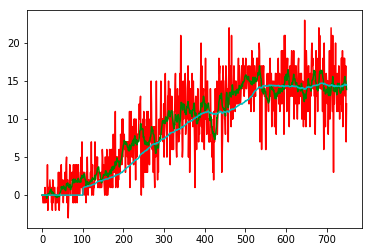

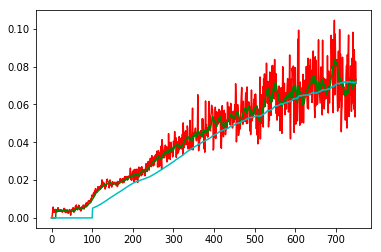

In [11]:
plot(scores)
plot(losses)

Finally let us run the agent with the learned Q-function:

In [12]:
replay_agent = learner.get_agent()
episode = env.generate_episode(replay_agent)
for count, step_data in enumerate(episode):
    print("=== step: " + str(count))
    print("score:    " + str(env.get_score()))


/Users/tkb/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


=== step: 0
score:    0.0
=== step: 1
score:    0.0
=== step: 2
score:    0.0
=== step: 3
score:    0.0
=== step: 4
score:    0.0
=== step: 5
score:    0.0
=== step: 6
score:    0.0
=== step: 7
score:    0.0
=== step: 8
score:    0.0
=== step: 9
score:    0.0
=== step: 10
score:    0.0
=== step: 11
score:    0.0
=== step: 12
score:    0.0
=== step: 13
score:    0.0
=== step: 14
score:    0.0
=== step: 15
score:    0.0
=== step: 16
score:    0.0
=== step: 17
score:    0.0
=== step: 18
score:    0.0
=== step: 19
score:    0.0
=== step: 20
score:    0.0
=== step: 21
score:    0.0
=== step: 22
score:    0.0
=== step: 23
score:    0.0
=== step: 24
score:    0.0
=== step: 25
score:    1.0
=== step: 26
score:    1.0
=== step: 27
score:    1.0
=== step: 28
score:    1.0
=== step: 29
score:    1.0
=== step: 30
score:    1.0
=== step: 31
score:    1.0
=== step: 32
score:    1.0
=== step: 33
score:    1.0
=== step: 34
score:    1.0
=== step: 35
score:    2.0
=== step: 36
score:    2.0
=== step: 3

=== step: 294
score:    17.0
=== step: 295
score:    17.0
=== step: 296
score:    17.0
=== step: 297
score:    18.0
=== step: 298
score:    18.0
=== step: 299
score:    18.0
